In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer ,BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import spacy
import torch.nn as nn
import torch.optim as optim
from torch.hub import load
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsRegressor





In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Comprobamos el uso de la tarjeta gráfica (GPU)
print(f"Using device: {device}")

Using device: cuda


In [3]:
file_path = 'full_format_recipes.json' 
data = pd.read_json(file_path) # Descargamos el archivo JSON
data.dropna(inplace=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True) # Se seleccionará todas las filas de manera aleatoria.



In [4]:

print(f"Dataset shape: {data.shape}") # Tamaño del dataset
print("Columns:", data.columns) # Columnas del dataset

Dataset shape: (10608, 11)
Columns: Index(['directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'title', 'ingredients', 'sodium'],
      dtype='object')


In [5]:
StringData = data[['directions', 'desc', 'rating','categories','title']].copy() # Columnas de interés para el análisis estadístico

StringDataWithNames=data[['directions', 'desc', 'rating','categories','title']].copy()






In [6]:
string_columns = ['directions', 'categories', 'desc', 'title'] 

for col in string_columns:
    StringDataWithNames[col] = StringDataWithNames[col].apply(
        lambda x: f"{col}: {', '.join(map(str, x))}" if isinstance(x, (list, np.ndarray)) else f"{col}: {x}" if pd.notnull(x) else x # Añadimos el nombre de las columnas antes de cada valor
    )


# Combinamos las cadenas de texto
StringDataWithNames['combined_text'] = (
    StringDataWithNames['desc'] +  " [SEP] "+ 
    StringDataWithNames['title'] + " [SEP] " +
    StringDataWithNames['directions'] + " [SEP] " +
    StringDataWithNames['categories']
)

# Antes de concatenar, comprobamos que son cadenas de texto
StringDataWithNames['Alltext'] = StringDataWithNames['directions'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " [SEP] " + StringDataWithNames['categories'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " [SEP] " + StringDataWithNames['desc'].apply(
    lambda x: str(x)
) + " [SEP] " + StringDataWithNames['title'].apply(
    lambda x: str(x)
)




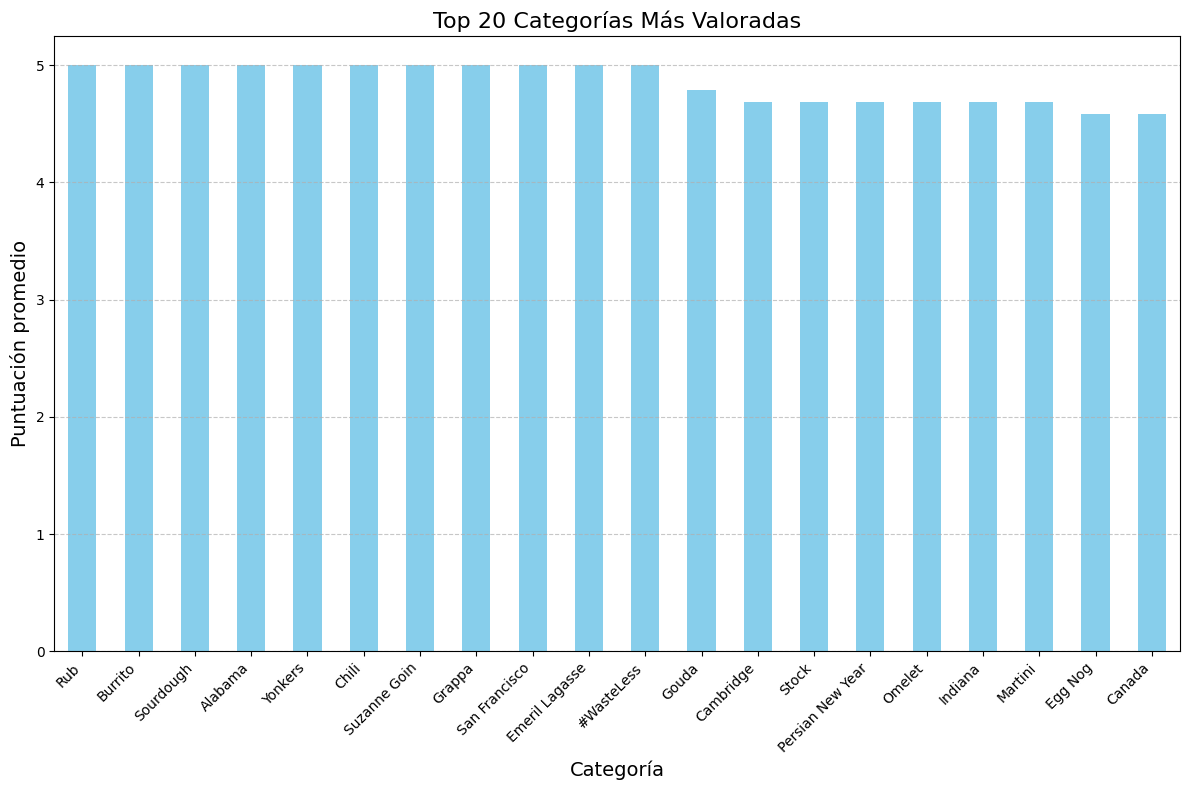

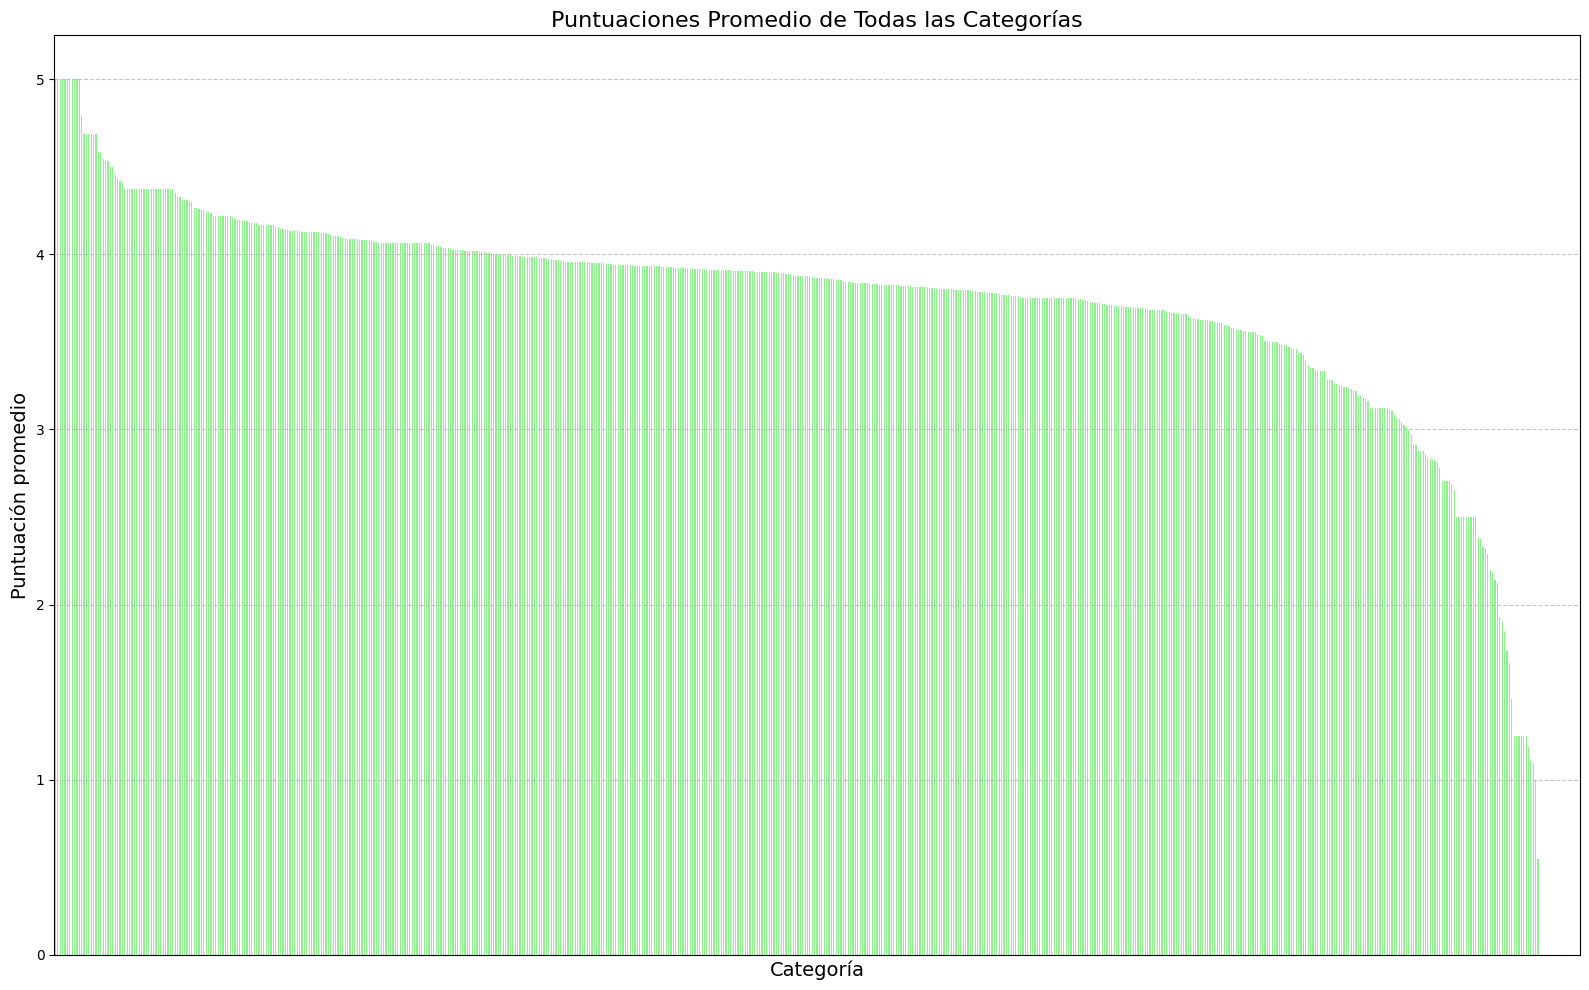

Número total de categorías únicas: 637


In [7]:


# Calculamos la media del rating por cada categoría
categories_exploded = data.explode('categories')
category_ratings = categories_exploded.groupby('categories')['rating'].mean().sort_values(ascending=False)

# Dibujamos el Top 20 de Categorías
plt.figure(figsize=(12, 8))
category_ratings.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Categorías Más Valoradas', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Dibujamos las categorías (sin indicar el eje X debido a la gran cantidad de filas)
plt.figure(figsize=(16, 10))
category_ratings.plot(kind='bar', color='lightgreen')
plt.title('Puntuaciones Promedio de Todas las Categorías', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks([])  # Quitamos las etiquetas del eje X
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculamos cuántas categorías son únicas
categorias_unicas = categories_exploded['categories'].nunique()
print(f"Número total de categorías únicas: {categorias_unicas}")




In [8]:
# Función para el preprocesamiento de texto
nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])


In [9]:


# Preprocesamos el las columnas directions, desc, categories y title
StringData['processed_directions'] = StringData['directions'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_desc'] = StringData['desc'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_categories'] = StringData['categories'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_title'] = StringData['title'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))







In [10]:
# Extract and normalize numeric features
numeric_features = data[['fat', 'protein', 'calories', 'sodium']].copy()
scaler = StandardScaler()
numeric_features = scaler.fit_transform(numeric_features)

In [11]:
print(StringData[['processed_directions', 'processed_desc', 'processed_categories', 'processed_title']].head())

                                processed_directions  \
0  simmer pea cream red pepper flake garlic teasp...   
1  Combine sugar orange juice concentrate water h...   
2  preheat oven F Butter flour cup Bundt pan Whis...   
3  heat peanut oil heavy large pot medium high he...   
4  stir ingredient small bowl blend season taste ...   

                                      processed_desc  \
0  zing fresh lemon enhance pea sweetness natural...   
1           Orange syrup sweeten cake fresh fruit go   
2  brandied whip cream add perfect finishing touc...   
3  hearty stew like soup inspire vietnamese pho h...   
4                                 nice toasted bagel   

                                processed_categories  \
0  Milk Cream Pasta Christmas Vegetarian Quick Ea...   
1  chocolate Dessert Bake Passover Orange Date Wa...   
2  Cake Fruit Dessert Currant Orange Pineapple Al...   
3  Soup Stew Beef Sauté Dinner Lunch Spring Noodl...   
4  Condiment Spread Dairy fish Herb Breakfast 

--------------------------------------------------------------------TF-IDF------------------------------------------------------------------

In [12]:
# TF-IDF: Vectorizamos según la columna correspondiente
vectorizer = TfidfVectorizer(max_features=100)
categories_tfidf = vectorizer.fit_transform(StringData['processed_categories'])
desc_tfidf = vectorizer.fit_transform(StringData['processed_desc'])
directions_tfidf = vectorizer.fit_transform(StringData['processed_directions'])
title_tfidf = vectorizer.fit_transform(StringData['processed_title'])

In [13]:
# Convertimos los datos de X a Y usando PyTorch 
X_TFIDF = torch.tensor(
    pd.concat(
        [pd.DataFrame(categories_tfidf.toarray()), pd.DataFrame(desc_tfidf.toarray()), pd.DataFrame(directions_tfidf.toarray()), pd.DataFrame(title_tfidf.toarray()), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [14]:
# Train-test-validation split
X_train_TFIDF, X_test_TFIDF, y_train, y_test = train_test_split(
   X_TFIDF, y, test_size=0.2, random_state=42)

X_val_TFIDF, X_test_TFIDF, y_val, y_test = train_test_split(
    X_test_TFIDF, y_test, test_size=0.5, random_state=42)  

--------------------------------------------------------------------WORD2VEC------------------------------------------------------------------

In [15]:
# Tokenizamos los datos
documents = StringData['processed_directions'].tolist() + StringData['processed_desc'].tolist() + \
            StringData['processed_categories'].tolist() + StringData['processed_title'].tolist()
tokenized_documents = [doc.split() for doc in documents]



In [16]:
# Entrenamos el modelo de Wor2Vec
word2vec_model = Word2Vec(sentences=tokenized_documents, vector_size=100, window=5, min_count=1, workers=4)

In [17]:
# Función para calcular el documento de embeddings
def get_doc_embedding(doc, model):
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [18]:

# Generamos Word2Vec embeddings para cada columna
StringData['directions_w2v'] = StringData['processed_directions'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['desc_w2v'] = StringData['processed_desc'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['categories_w2v'] = StringData['processed_categories'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['title_w2v'] = StringData['processed_title'].apply(lambda x: get_doc_embedding(x, word2vec_model))


In [19]:

# Combinamos Word2Vec embeddings en una matriz
w2v_features = np.array(StringData['directions_w2v'].tolist()) + \
               np.array(StringData['desc_w2v'].tolist()) + \
               np.array(StringData['categories_w2v'].tolist()) + \
               np.array(StringData['title_w2v'].tolist())


In [20]:
# Convertimos de nuevo los datos usando PyTorch
X_W2V = torch.tensor(
    pd.concat(
        [pd.DataFrame(w2v_features), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

#
# final_features = np.hstack([w2v_features, numeric_features])


In [21]:
# Train-test split
X_train_W2V, X_test_W2V, y_train, y_test = train_test_split(
   X_W2V, y, test_size=0.2, random_state=42)
X_val_W2V, X_test_W2V, y_val, y_test = train_test_split(
    X_test_W2V, y_test, test_size=0.5, random_state=42)  

--------------------------------------------------------------------BERT------------------------------------------------------------------

In [22]:

# Usamos BERT embeddings para embeddings contextuales
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [23]:
def get_bert_embeddings(text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, max_length=64, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    # Use the CLS token embeddings as the document representation
    return outputs.last_hidden_state[:, 0, :].numpy()



In [24]:
#X_text_Prebert = StringDataWithNames['Alltext']
#X_embeddings = get_bert_embeddings(X_text_Prebert.tolist())
embeddings_directions = get_bert_embeddings(StringDataWithNames['directions'].tolist())
embeddings_desc = get_bert_embeddings(StringDataWithNames['desc'].tolist())
embeddings_categories = get_bert_embeddings(StringDataWithNames['categories'].tolist())
embeddings_title = get_bert_embeddings(StringDataWithNames['title'].tolist())

# Juntamos todos los datos
X_embeddings = np.hstack([
    embeddings_directions,
    embeddings_desc,
    embeddings_categories,
    embeddings_title,
    numeric_features
])





In [25]:
# Combinamos los BERT embeddings
X_BERT = torch.tensor(
    pd.concat(
        [pd.DataFrame(X_embeddings), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [26]:
# Split BERT
X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    X_BERT, y, test_size=0.2, random_state=42)

X_val_bert, X_test_bert, y_val, y_test = train_test_split(
    X_test_bert, y_test, test_size=0.5, random_state=42)

-----------------------------------------------------------------------------Before Starting---------------------------------------------------------------------

In [27]:

# Calculate the mean of the 'rating' feature
mean_rating = StringData['rating'].mean()

# Create a prediction array with the mean value for all samples
predictions = np.full_like(StringData['rating'], mean_rating)

# Calculate the MAE
mae = mean_absolute_error(StringData['rating'], predictions)

print(f"Mean rating: {mean_rating}")
print(f"MAE when predicting the mean: {mae}")

Mean rating: 3.8045578808446456
MAE when predicting the mean: 0.828418629242508


--------------------------------------------------------------------KNN------------------------------------------------------------------

In [28]:

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_TFIDF, y_train)

KNeighborsRegressor()

In [29]:
# Ensure X_test and y_test are numpy arrays
#X_test_bert_np = X_train_bert.cpu().numpy() if isinstance(X_train_bert, torch.Tensor) else X_train_bert
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_TFIDF)
print("KNN MSE:", mean_squared_error(y_test, knn_predictions))
print("KNN MAE:", mean_absolute_error(y_test, knn_predictions))

KNN MSE: 1.562175989151001
KNN MAE: 0.8282281160354614


In [30]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_W2V, y_train)

KNeighborsRegressor()

In [31]:
# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_W2V)
print("KNN MSE:", mean_squared_error(y_test, knn_predictions))
print("KNN MAE:",  mean_absolute_error(y_test, knn_predictions))


KNN MSE: 1.5216187238693237
KNN MAE: 0.8225730657577515


In [32]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_bert, y_train)


KNeighborsRegressor()

In [33]:

# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_bert)
print("KNN MSE:", mean_squared_error(y_test_np, knn_predictions))
print("KNN MAE:",  mean_absolute_error(y_test,knn_predictions))


KNN MSE: 1.4450842142105103
KNN MAE: 0.7875824570655823


--------------------------------------------------------------------SIMPLE NN------------------------------------------------------------------

----------------------------------------------------------------------SIMPLE NN WITH W2V-----------------------------------------------------------

In [34]:
# Train a neural network using PyTorch
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)



In [35]:
input_size = X_train_W2V.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_W2V).float().to(device) if isinstance(X_train_W2V, np.ndarray) else X_train_W2V.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_W2V).float().to(device) if isinstance(X_val_W2V, np.ndarray) else X_val_W2V.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_W2V).float().to(device) if isinstance(X_test_W2V, np.ndarray) else X_test_W2V.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [37]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 200  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")



Epoch 1, Training Loss: 3.7460391521453857, Validation Loss: 3.550027370452881
Epoch 2, Training Loss: 3.5190207958221436, Validation Loss: 3.3208680152893066
Epoch 3, Training Loss: 3.300405979156494, Validation Loss: 3.0942749977111816
Epoch 4, Training Loss: 3.0843780040740967, Validation Loss: 2.868540048599243
Epoch 5, Training Loss: 2.8693013191223145, Validation Loss: 2.6430861949920654
Epoch 6, Training Loss: 2.6544458866119385, Validation Loss: 2.419243574142456
Epoch 7, Training Loss: 2.4399216175079346, Validation Loss: 2.1952736377716064
Epoch 8, Training Loss: 2.2247860431671143, Validation Loss: 1.9717737436294556
Epoch 9, Training Loss: 2.0090646743774414, Validation Loss: 1.7563272714614868
Epoch 10, Training Loss: 1.7964961528778076, Validation Loss: 1.5550994873046875
Epoch 11, Training Loss: 1.593733310699463, Validation Loss: 1.3719569444656372
Epoch 12, Training Loss: 1.411057949066162, Validation Loss: 1.2256895303726196
Epoch 13, Training Loss: 1.2624197006225586

In [38]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")



Neural Network Test Loss: 0.7572268843650818
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.4815164804458618
 - Mean Absolute Error (MAE): 0.7572270035743713


----------------------------------------------------------------------SIMPLE NN WITH TFIDF-----------------------------------------------------------

In [39]:
input_size = X_train_TFIDF.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_TFIDF).float().to(device) if isinstance(X_train_TFIDF, np.ndarray) else X_train_TFIDF.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_TFIDF).float().to(device) if isinstance(X_val_TFIDF, np.ndarray) else X_val_TFIDF.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_TFIDF).float().to(device) if isinstance(X_test_TFIDF, np.ndarray) else X_test_TFIDF.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [41]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 200  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")

Epoch 1, Training Loss: 3.753009080886841, Validation Loss: 3.769986867904663
Epoch 2, Training Loss: 3.7226994037628174, Validation Loss: 3.738729953765869
Epoch 3, Training Loss: 3.692361831665039, Validation Loss: 3.707069158554077
Epoch 4, Training Loss: 3.66166090965271, Validation Loss: 3.6746726036071777
Epoch 5, Training Loss: 3.6302783489227295, Validation Loss: 3.641298532485962
Epoch 6, Training Loss: 3.59792160987854, Validation Loss: 3.606618881225586
Epoch 7, Training Loss: 3.564310073852539, Validation Loss: 3.5704455375671387
Epoch 8, Training Loss: 3.529371976852417, Validation Loss: 3.5326619148254395
Epoch 9, Training Loss: 3.492973804473877, Validation Loss: 3.493222713470459
Epoch 10, Training Loss: 3.4548861980438232, Validation Loss: 3.45205020904541
Epoch 11, Training Loss: 3.415086507797241, Validation Loss: 3.4091153144836426
Epoch 12, Training Loss: 3.3735573291778564, Validation Loss: 3.364426851272583
Epoch 13, Training Loss: 3.3302791118621826, Validation 

In [42]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7563222050666809
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.4217411279678345
 - Mean Absolute Error (MAE): 0.7563222050666809


----------------------------------------------------------------------SIMPLE NN WITH BERT-----------------------------------------------------------

In [43]:
input_size = X_train_bert.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_bert).float().to(device) if isinstance(X_train_bert, np.ndarray) else X_train_bert.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_bert).float().to(device) if isinstance(X_val_bert, np.ndarray) else X_val_bert.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_bert).float().to(device) if isinstance(X_test_bert, np.ndarray) else X_test_bert.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [45]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 500  # Number of epochs to wait before stopping
tolerance = 1e-5  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")

Epoch 1, Training Loss: 3.977250576019287, Validation Loss: 1.8720600605010986
Epoch 2, Training Loss: 1.8785666227340698, Validation Loss: 0.8762497305870056
Epoch 8, Training Loss: 1.0827068090438843, Validation Loss: 0.807938277721405
Epoch 9, Training Loss: 0.8393709063529968, Validation Loss: 0.7901053428649902
Epoch 10, Training Loss: 0.8359894752502441, Validation Loss: 0.9304924011230469
Epoch 12, Training Loss: 0.8752721548080444, Validation Loss: 0.7574819922447205
Epoch 16, Training Loss: 0.8388106822967529, Validation Loss: 0.7494763731956482
Epoch 19, Training Loss: 0.8408455848693848, Validation Loss: 0.7368601560592651
Epoch 20, Training Loss: 0.7755112051963806, Validation Loss: 0.7596533298492432
Epoch 24, Training Loss: 0.7904691696166992, Validation Loss: 0.7344518303871155
Epoch 30, Training Loss: 0.789496660232544, Validation Loss: 0.7476626038551331
Epoch 31, Training Loss: 0.7788686156272888, Validation Loss: 0.7319834232330322
Epoch 34, Training Loss: 0.77511847

In [46]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7243208289146423
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.424782633781433
 - Mean Absolute Error (MAE): 0.7243208289146423


------------------------------------------------------------------------COMPLEX MODEL------------------------------------------------------------------

----------------------------------------------------------------------COMPLEX NN WITH W2V-----------------------------------------------------------

In [47]:


class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=None, dropout_rate=0.3):
        super(ComplexNN, self).__init__()
        
        if hidden_sizes is None:
            hidden_sizes = [256, 128, 64]  # Default hidden layer sizes
        
        layers = []
        in_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            in_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        # Define the sequential model
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(x)





In [48]:
input_size = X_train_W2V.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [49]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_W2V).float().to(device) if isinstance(X_train_W2V, np.ndarray) else X_train_W2V.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_W2V).float().to(device) if isinstance(X_val_W2V, np.ndarray) else X_val_W2V.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_W2V).float().to(device) if isinstance(X_test_W2V, np.ndarray) else X_test_W2V.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [50]:


# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.8693108558654785, Validation Loss: 3.85412859916687
Epoch 2, Training Loss: 3.8485288619995117, Validation Loss: 3.8104348182678223
Epoch 3, Training Loss: 3.8416812419891357, Validation Loss: 3.7728145122528076
Epoch 4, Training Loss: 3.830476760864258, Validation Loss: 3.7439286708831787
Epoch 5, Training Loss: 3.823636531829834, Validation Loss: 3.722093343734741
Epoch 6, Training Loss: 3.81970477104187, Validation Loss: 3.703118085861206
Epoch 7, Training Loss: 3.8147904872894287, Validation Loss: 3.6876895427703857
Epoch 8, Training Loss: 3.8023314476013184, Validation Loss: 3.6730525493621826
Epoch 9, Training Loss: 3.791839599609375, Validation Loss: 3.6598658561706543
Epoch 10, Training Loss: 3.782681941986084, Validation Loss: 3.647393226623535
Epoch 11, Training Loss: 3.7793869972229004, Validation Loss: 3.6365139484405518
Epoch 12, Training Loss: 3.770097017288208, Validation Loss: 3.6285343170166016
Epoch 13, Training Loss: 3.7708709239959717, Vali

In [51]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")


Neural Network Test Loss: 0.697309672832489
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.3169665336608887
 - Mean Absolute Error (MAE): 0.697309672832489


----------------------------------------------------------------------COMPLEX NN WITH TFIDF-----------------------------------------------------------

In [52]:
input_size = X_train_TFIDF.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [53]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_TFIDF).float().to(device) if isinstance(X_train_TFIDF, np.ndarray) else X_train_TFIDF.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_TFIDF).float().to(device) if isinstance(X_val_TFIDF, np.ndarray) else X_val_TFIDF.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_TFIDF).float().to(device) if isinstance(X_test_TFIDF, np.ndarray) else X_test_TFIDF.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [54]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6 # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.813828945159912, Validation Loss: 3.8040683269500732
Epoch 2, Training Loss: 3.783501625061035, Validation Loss: 3.7772867679595947
Epoch 3, Training Loss: 3.7701995372772217, Validation Loss: 3.749785900115967
Epoch 4, Training Loss: 3.757051944732666, Validation Loss: 3.7230634689331055
Epoch 5, Training Loss: 3.754612922668457, Validation Loss: 3.6969120502471924
Epoch 6, Training Loss: 3.7420599460601807, Validation Loss: 3.671705961227417
Epoch 7, Training Loss: 3.730393886566162, Validation Loss: 3.64825701713562
Epoch 8, Training Loss: 3.7213969230651855, Validation Loss: 3.627873420715332
Epoch 9, Training Loss: 3.712888240814209, Validation Loss: 3.6093087196350098
Epoch 10, Training Loss: 3.7126119136810303, Validation Loss: 3.592066526412964
Epoch 11, Training Loss: 3.7035059928894043, Validation Loss: 3.5747036933898926
Epoch 12, Training Loss: 3.69610595703125, Validation Loss: 3.561781167984009
Epoch 13, Training Loss: 3.6803553104400635, Validat

In [55]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.678719699382782
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.1926559209823608
 - Mean Absolute Error (MAE): 0.6787196397781372


----------------------------------------------------------------------COMPLEX NN WITH BERT-----------------------------------------------------------

In [56]:
input_size = X_train_bert.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [57]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_bert).float().to(device) if isinstance(X_train_bert, np.ndarray) else X_train_bert.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_bert).float().to(device) if isinstance(X_val_bert, np.ndarray) else X_val_bert.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_bert).float().to(device) if isinstance(X_test_bert, np.ndarray) else X_test_bert.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [58]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.875490188598633, Validation Loss: 3.8387107849121094
Epoch 2, Training Loss: 3.8284802436828613, Validation Loss: 3.8342339992523193
Epoch 10, Training Loss: 3.7563302516937256, Validation Loss: 3.9779844284057617
Epoch 20, Training Loss: 3.6709814071655273, Validation Loss: 4.1327433586120605
Epoch 30, Training Loss: 3.524176836013794, Validation Loss: 3.9406137466430664
Epoch 33, Training Loss: 3.4871082305908203, Validation Loss: 3.7868638038635254
Epoch 34, Training Loss: 3.453770637512207, Validation Loss: 3.7143282890319824
Epoch 35, Training Loss: 3.4335246086120605, Validation Loss: 3.6588497161865234
Epoch 36, Training Loss: 3.432309865951538, Validation Loss: 3.571162462234497
Epoch 37, Training Loss: 3.39974308013916, Validation Loss: 3.5214619636535645
Epoch 38, Training Loss: 3.3778231143951416, Validation Loss: 3.453239679336548
Epoch 39, Training Loss: 3.364412546157837, Validation Loss: 3.447796583175659
Epoch 40, Training Loss: 3.3578150272369

In [59]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.6488772034645081
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.218009114265442
 - Mean Absolute Error (MAE): 0.6488772630691528


------------------------------------------------------------------------FINE TUNNING FROM HUGGING FACE--------------------------------------------------------------------------

In [102]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device='cpu'
labels = torch.tensor(data['rating'].values, dtype=torch.float32)

# Prepare the numeric features
numeric_features = torch.tensor(
    numeric_features,
    dtype=torch.float32
).to(device)

# Split data into train, validation, and test sets
train_texts, temp_texts, train_numeric, temp_numeric, train_labels, temp_labels = train_test_split(
    StringDataWithNames['Alltext'], numeric_features, labels, test_size=0.3, random_state=42
)

val_texts, test_texts, val_numeric, test_numeric, val_labels, test_labels = train_test_split(
    temp_texts, temp_numeric, temp_labels, test_size=0.5, random_state=42
)



C:\Users\Carlo\AppData\Local\Temp\ipykernel_8860\2655901024.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  numeric_features = torch.tensor(


In [103]:
def tokenize_data(df, max_length=64):
    return tokenizer(
        df.tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )


In [104]:



train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)
test_encodings = tokenize_data(test_texts)


In [105]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, numeric_features, labels):
        self.encodings = encodings
        self.numeric_features = numeric_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['numeric_features'] = self.numeric_features[idx]
        item['labels'] = self.labels[idx]
        return item

In [106]:

train_dataset = CustomDataset(train_encodings, train_numeric, train_labels)
val_dataset = CustomDataset(val_encodings, val_numeric, val_labels)
test_dataset = CustomDataset(test_encodings, test_numeric, test_labels)

In [107]:
class BERTRegressionWithNumeric(torch.nn.Module):
    def __init__(self, bert_model_name, num_numeric_features):
        super(BERTRegressionWithNumeric, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.regression_head = torch.nn.Sequential(
            torch.nn.Linear(self.bert.config.hidden_size + num_numeric_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask, numeric_features):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embeddings
        combined_features = torch.cat([cls_embeddings, numeric_features], dim=1)
        return self.regression_head(combined_features)

# Initialize model

In [108]:
model = BERTRegressionWithNumeric('bert-base-uncased', num_numeric_features=numeric_features.size(1))
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.MSELoss()

In [109]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch"
)

In [110]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        numeric_features = inputs.pop("numeric_features")
        outputs = model(**inputs, numeric_features=numeric_features)
        loss = loss_fn(outputs.squeeze(), labels)
        return (loss, outputs) if return_outputs else loss

In [111]:

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)
# Train the model
trainer.train()

  0%|          | 0/2787 [00:00<?, ?it/s]

KeyError: 'labels'

In [ ]:
# Save the model
trainer.save_model('./fine_tuned_bert_with_numeric')

In [ ]:
# Evaluate on test dataset
test_predictions = trainer.predict(test_dataset).predictions.squeeze()
test_labels_numpy = test_labels.numpy()

In [77]:
device='cpu'